# 概要
各々のモデルを用いて自転車を割り当てた場合のリバランスコストの推移を比較して、モデルの優位性を確認するためのプログラム

In [ ]:
import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from pandas import DataFrame
from scipy.interpolate import PchipInterpolator

In [ ]:
# データのインポート
df_time_series_neighborhood = pd.read_csv('/content/result_by_neighborhoodBasedDispatchModel.csv')
df_time_series_optimization = pd.read_csv('/content/result_by_optimizationBasedDispatchModel.csv')
df_time_series_random = pd.read_csv('/content/result_by_randomBasedDispatchModel.csv')
df_time_series_withoutStackOpt = pd.read_csv('/content/result_by_withoutStackOptBasedDispatchModel.csv')

print(df_time_series_neighborhood.info())
print(df_time_series_optimization.info())
print(df_time_series_random.info())
print(df_time_series_withoutStackOpt.info())

df_time_series = [
    df_time_series_random,
    df_time_series_neighborhood,
    df_time_series_withoutStackOpt,
    df_time_series_optimization
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45310 entries, 0 to 45309
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             45310 non-null  int64  
 1   time                   45310 non-null  int64  
 2   matching_success_rate  45310 non-null  float64
 3   bikes_occupied_rate    45310 non-null  float64
 4   rebalance_cost         45310 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1440 non-null   int64  
 1   time                   1440 non-null   object 
 2   matching_success_rate  1440 non-null   float64
 3   bikes_occupied_rate    1440 non-null   float64
 4   rebalance_cost         1440 non-null   float64
dty

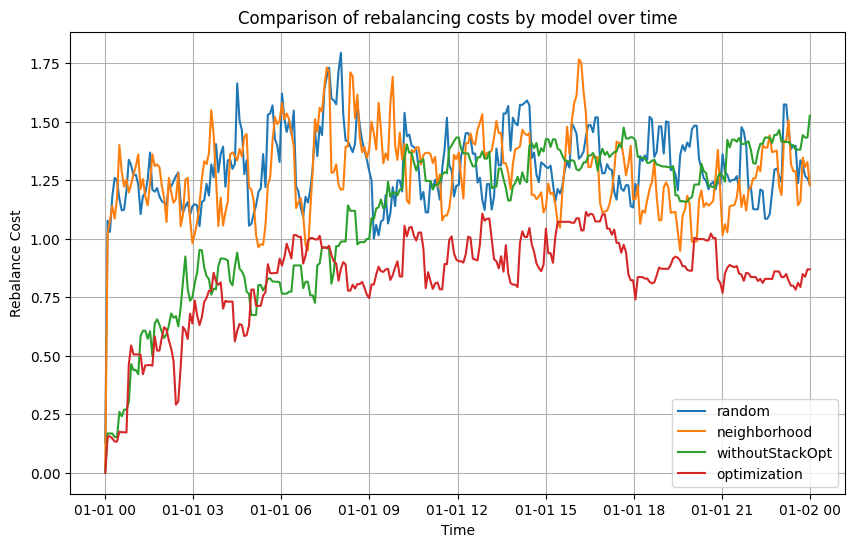

In [ ]:
# それぞれのdf_time_serieのrebalance_costカラムの推移を比較する図をプロットする

# まず'time'カラムをdatetimeオブジェクトに変換する。
df_time_series_optimization['time'] = pd.to_datetime(df_time_series_optimization['time'])

# 秒に変換
time = df_time_series_random['time'].values / 1e9
stack_time = df_time_series_optimization['time'].astype('int64') / 1e9

# 補間のための新しい時間データを作成
time_new = np.linspace(time.min(), time.max(), 300)
stack_time_new = np.linspace(stack_time.min(), stack_time.max(), 300)

# PCHIP補間
pchip_rebalance_cost_random = PchipInterpolator(time, df_time_series_random['rebalance_cost'])
rebalance_cost_smooth_random = pchip_rebalance_cost_random(time_new)

pchip_rebalance_cost_neighborhood = PchipInterpolator(time, df_time_series_neighborhood['rebalance_cost'])
rebalance_cost_smooth_neighborhood = pchip_rebalance_cost_neighborhood(time_new)

pchip_rebalance_cost_withoutStackOpt = PchipInterpolator(time, df_time_series_withoutStackOpt['rebalance_cost'])
rebalance_cost_smooth_withoutStackOpt = pchip_rebalance_cost_withoutStackOpt(time_new)

pchip_rebalance_cost_optimization = PchipInterpolator(stack_time, df_time_series_optimization['rebalance_cost'])
rebalance_cost_smooth_optimization = pchip_rebalance_cost_optimization(stack_time_new)

# プロット
fig, ax1 = plt.subplots(figsize=(10, 6))

# 新しい時間データをDateTimeに変換してプロット
time_new_datetime = pd.to_datetime(time_new * 1e9)

# 各モデルのリバランスコストの推移をプロット
plt.plot(time_new_datetime, rebalance_cost_smooth_random, label='Random')
plt.plot(time_new_datetime, rebalance_cost_smooth_neighborhood, label='neighborhood') # Add the other plots back in
plt.plot(time_new_datetime, rebalance_cost_smooth_withoutStackOpt, label='withoutStackOpt')
plt.plot(time_new_datetime, rebalance_cost_smooth_optimization, label='optimization')
# plt.plot(df_time_series_optimization['time'], df_time_series_optimization['rebalance_cost'], label='Optimization')
# plt.plot(df_time_series_random['time'], df_time_series_random['rebalance_cost'], label='Random')
# plt.plot(df_time_series_withoutStackOpt['time'], df_time_series_withoutStackOpt['rebalance_cost'], label='Without Stack Opt')

# 軸ラベル、凡例、タイトルを設定
plt.xlabel('Time')
plt.ylabel('Rebalance Cost')
plt.legend()
plt.grid(True)
plt.title('Comparison of rebalancing costs by model over time')

# グラフを表示
plt.show()